In [1]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 16384 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "codellama/CodeLlama-13b-Instruct-hf",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🦥 Unsloth Zoo will now patch everything to make training faster!


/usr/local/lib/python3.10/dist-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


INFO 05-13 09:13:15 [importing.py:53] Triton module has been replaced with a placeholder.


INFO 05-13 09:13:15 [__init__.py:239] Automatically detected platform cuda.


2025-05-13 09:13:17,555	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


==((====))==  Unsloth 2025.4.7: Fast Llama patching. Transformers: 4.51.3. vLLM: 0.8.5.
   \\   /|    Tesla V100-SXM2-32GB. Num GPUs = 1. Max memory: 31.749 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!



Loading checkpoint shards:   0%|                                                                     | 0/3 [00:00<?, ?it/s]


Loading checkpoint shards:  33%|████████████████████▎                                        | 1/3 [00:29<00:58, 29.13s/it]


Loading checkpoint shards:  67%|████████████████████████████████████████▋                    | 2/3 [00:44<00:20, 20.97s/it]


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████| 3/3 [00:50<00:00, 14.18s/it]


Loading checkpoint shards: 100%|█████████████████████████████████████████████████████████████| 3/3 [00:50<00:00, 16.83s/it]

codellama/CodeLlama-13b-Instruct-hf does not have a padding token! Will use pad_token = <unk>.


In [2]:
# lora_rank = 128
lora_rank = 64

model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = lora_rank,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 42,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.4.7 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


In [ ]:
from datasets import load_dataset

# Define the paths to your dataset files
data_files = {
    'train': 'smart_contract_train.csv',
    'val': 'smart_contract_val.csv',
    'test': 'smart_contract_test.csv'
}

# Load the dataset
dataset = load_dataset('csv', data_files=data_files)

In [ ]:
import random

SYSTEM_PROMPT = """You are the smartest AI solidity smart contract security auditor in the world."""

PROMPTS = """You need to analyze the given function and classify it as "Vulnerable Code" or "Safe Code" based on potential security risks.
    
    This is the function we need to audit:
    ```solidity
    {code}
    ```
    
Answer: """

def make_conversational(examples):
    code = examples['code']
    vulnerable = "Vulnerable Code" if examples['vulnerable'] == 1 else "Safe Code"
    conversation = [{"role": "system", "content": SYSTEM_PROMPT}, 
                    {"role": "user", "content": PROMPTS.format(code=code)},
                    {"role": "assistant", "content": vulnerable}]
    return { "conversations" : conversation, }

dataset = dataset.map(make_conversational)
dataset = dataset.remove_columns(["project_id","code", "code_analysis", "vulnerable"])

In [5]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama",
)

def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }

dataset = dataset.map(formatting_prompts_func, batched = True,)

In [6]:
dataset['train'][5]["conversations"]

[{'content': 'You are the smartest AI solidity smart contract security auditor in the world.',
  'role': 'system'},
 {'content': 'You need to analyze the given function and classify it as "Vulnerable Code" or "Safe Code" based on potential security risks.\n    \n    This is the function we need to audit:\n    ```solidity\n    function registerDeposit(\n        address trader,\n        address token,\n        uint256 depositAmount\n    ) external override returns (uint256 extinguishableDebt) {\n        require(\n            isMarginTrader(msg.sender),\n            "Calling contract not authorized to deposit"\n        );\n\n        CrossMarginAccount storage account = marginAccounts[trader];\n        account.lastDepositBlock = block.number;\n\n        if (account.borrowed[token] > 0) {\n            extinguishableDebt = min(depositAmount, account.borrowed[token]);\n            extinguishDebt(account, token, extinguishableDebt);\n            totalShort[token] -= extinguishableDebt;\n      

In [7]:
dataset['train'][5]["text"]

'<s>[INST] <<SYS>>\nYou are the smartest AI solidity smart contract security auditor in the world.\n<</SYS>>\n\nYou need to analyze the given function and classify it as "Vulnerable Code" or "Safe Code" based on potential security risks.\n    \n    This is the function we need to audit:\n    ```solidity\n    function registerDeposit(\n        address trader,\n        address token,\n        uint256 depositAmount\n    ) external override returns (uint256 extinguishableDebt) {\n        require(\n            isMarginTrader(msg.sender),\n            "Calling contract not authorized to deposit"\n        );\n\n        CrossMarginAccount storage account = marginAccounts[trader];\n        account.lastDepositBlock = block.number;\n\n        if (account.borrowed[token] > 0) {\n            extinguishableDebt = min(depositAmount, account.borrowed[token]);\n            extinguishDebt(account, token, extinguishableDebt);\n            totalShort[token] -= extinguishableDebt;\n        }\n\n        // 

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

train_dataset = dataset['train']
val_dataset = dataset['val']

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = val_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 4,
    packing = False, 
    args = TrainingArguments(
        eval_strategy="steps",
        eval_steps=500,
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 8,
        warmup_ratio = 0.1,
        num_train_epochs = 5,
        learning_rate = 2e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit", 
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        load_best_model_at_end=True,
        output_dir = "outputs_codellama_dedup",
        report_to = "none", 
    ),
)

Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [9]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<</SYS>>\n\n",
    response_part = "[/INST]",
)

In [10]:
tokenizer.decode(trainer.train_dataset[5]["input_ids"])

'<s><s> [INST] <<SYS>>\nYou are the smartest AI solidity smart contract security auditor in the world.\n<</SYS>>\n\nYou need to analyze the given function and classify it as "Vulnerable Code" or "Safe Code" based on potential security risks.\n    \n    This is the function we need to audit:\n    ```solidity\n    function registerDeposit(\n        address trader,\n        address token,\n        uint256 depositAmount\n    ) external override returns (uint256 extinguishableDebt) {\n        require(\n            isMarginTrader(msg.sender),\n            "Calling contract not authorized to deposit"\n        );\n\n        CrossMarginAccount storage account = marginAccounts[trader];\n        account.lastDepositBlock = block.number;\n\n        if (account.borrowed[token] > 0) {\n            extinguishableDebt = min(depositAmount, account.borrowed[token]);\n            extinguishDebt(account, token, extinguishableDebt);\n            totalShort[token] -= extinguishableDebt;\n        }\n\n       

In [11]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[5]["labels"]])

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Safe Code </s>'

In [12]:
tokenizer.decode(trainer.eval_dataset[5]["input_ids"])

'<s><s> [INST] <<SYS>>\nYou are the smartest AI solidity smart contract security auditor in the world.\n<</SYS>>\n\nYou need to analyze the given function and classify it as "Vulnerable Code" or "Safe Code" based on potential security risks.\n    \n    This is the function we need to audit:\n    ```solidity\n    function wrap(address to_, address from_) external {\n        require(!isShutdown, "shutdown");\n        uint256 amount_ = IERC20(convexToken).balanceOf(address(this));\n        require(amount_ > 0, "No convex token to wrap");\n\n        _checkpoint([address(0), from_]);\n        _mint(to_, amount_);\n        IRewardStaking(convexPool).stake(amount_);\n\n        emit Deposited(msg.sender, to_, amount_, false);\n    }\n\nfunction unwrap(address to_) external {\n        require(!isShutdown, "shutdown");\n        uint256 amount_ = _balanceOf[address(this)];\n        require(amount_ > 0, "No wrapped convex token");\n\n        _checkpoint([address(0), to_]);\n        _burn(address(t

In [13]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.eval_dataset[5]["labels"]])

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Vulnerable Code </s>'

In [14]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,324 | Num Epochs = 5 | Total steps = 825
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 8 x 1) = 8
 "-____-"     Trainable parameters = 250,347,520/13,000,000,000 (1.93% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
500,0.068000,0.059944


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [ ]:
test_dataset = dataset['test']
test_dataset = test_dataset.map(lambda row: {'label':row['conversations'][-1]['content']})
test_dataset = test_dataset.map(lambda row: {'conversations':row['conversations'][:-1]})

In [ ]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama",
)
FastLanguageModel.for_inference(model) 

messages = test_dataset['conversations'][1]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize = True,
    add_generation_prompt = True, 
    return_tensors = "pt",
).to("cuda")

outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                         temperature = 1.5, min_p = 0.1)
tokenizer.batch_decode(outputs)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['<s> [INST] <<SYS>>\nYou are the smartest AI solidity smart contract security auditor in the world.\n<</SYS>>\n\nYou need to analyze the given function and classify it as "Vulnerable Code" or "Safe Code" based on potential security risks.\n    \n    This is the function we need to audit:\n    ```solidity\n    function _getAdmin(uint256 adminEpoch, uint256 index) internal view returns (address) {\n        return getAddress(_getAdminKey(adminEpoch, index));\n    }\n\nfunction _isAdmin(uint256 adminEpoch, address account) internal view returns (bool) {\n        return getBool(_getIsAdminKey(adminEpoch, account));\n    }\n\nfunction _setAdminEpoch(uint256 adminEpoch) internal {\n        _setUint(KEY_ADMIN_EPOCH, adminEpoch);\n    }\n    ```\n    \nAnswer:  [/INST] Safe Code </s>']

In [ ]:
from unsloth.chat_templates import get_chat_template
from tqdm import tqdm
import re

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama",
)
FastLanguageModel.for_inference(model) 

pattern = r"\[/INST](.*?)</s>"

y_pred = []

for messages in tqdm(test_dataset['conversations']):
    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize = True,
        add_generation_prompt = True, 
        return_tensors = "pt",
    ).to("cuda")

    outputs = model.generate(input_ids = inputs, max_new_tokens = 64, use_cache = True,
                             temperature = 0.6, min_p = 0.1)
    decoded_output = tokenizer.batch_decode(outputs)[0]
    
    match = re.search(pattern, decoded_output, re.DOTALL)
    extracted_label = match.group(1).strip() if match else "Unknown"

    y_pred.append(extracted_label)


  0%|                                                                                              | 0/278 [00:00<?, ?it/s]


  0%|▎                                                                                     | 1/278 [00:00<02:43,  1.69it/s]


  1%|▌                                                                                     | 2/278 [00:01<02:44,  1.68it/s]


  1%|▉                                                                                     | 3/278 [00:01<02:43,  1.68it/s]


  1%|█▏                                                                                    | 4/278 [00:02<03:46,  1.21it/s]


  2%|█▌                                                                                    | 5/278 [00:03<03:22,  1.35it/s]


  2%|█▊                                                                                    | 6/278 [00:04<03:24,  1.33it/s]


  3%|██▏                                                                                   | 7/278 [00:05<03:24,  1.32it/s]


  3%|██▍                                                                                   | 8/278 [00:05<03:09,  1.42it/s]


  3%|██▊                                                                                   | 9/278 [00:06<02:59,  1.50it/s]


  4%|███                                                                                  | 10/278 [00:06<02:57,  1.51it/s]


  4%|███▎                                                                                 | 11/278 [00:07<03:11,  1.39it/s]


  4%|███▋                                                                                 | 12/278 [00:08<03:01,  1.47it/s]


  5%|███▉                                                                                 | 13/278 [00:08<02:51,  1.55it/s]


  5%|████▎                                                                                | 14/278 [00:09<02:46,  1.59it/s]


  5%|████▌                                                                                | 15/278 [00:10<02:42,  1.62it/s]


  6%|████▉                                                                                | 16/278 [00:10<02:39,  1.64it/s]


  6%|█████▏                                                                               | 17/278 [00:11<03:02,  1.43it/s]


  6%|█████▌                                                                               | 18/278 [00:12<03:25,  1.26it/s]


  7%|█████▊                                                                               | 19/278 [00:13<03:16,  1.32it/s]


  7%|██████                                                                               | 20/278 [00:14<03:31,  1.22it/s]


  8%|██████▍                                                                              | 21/278 [00:14<03:12,  1.33it/s]


  8%|██████▋                                                                              | 22/278 [00:15<03:12,  1.33it/s]


  8%|███████                                                                              | 23/278 [00:16<03:00,  1.41it/s]


  9%|███████▎                                                                             | 24/278 [00:17<03:09,  1.34it/s]


  9%|███████▋                                                                             | 25/278 [00:17<03:09,  1.33it/s]


  9%|███████▉                                                                             | 26/278 [00:18<03:10,  1.32it/s]


 10%|████████▎                                                                            | 27/278 [00:19<03:14,  1.29it/s]


 10%|████████▌                                                                            | 28/278 [00:20<03:19,  1.25it/s]


 10%|████████▊                                                                            | 29/278 [00:20<03:02,  1.36it/s]


 11%|█████████▏                                                                           | 30/278 [00:21<03:08,  1.31it/s]


 11%|█████████▍                                                                           | 31/278 [00:22<02:59,  1.38it/s]


 12%|█████████▊                                                                           | 32/278 [00:22<02:48,  1.46it/s]


 12%|██████████                                                                           | 33/278 [00:23<02:45,  1.48it/s]


 12%|██████████▍                                                                          | 34/278 [00:24<02:36,  1.56it/s]


 13%|██████████▋                                                                          | 35/278 [00:24<02:30,  1.61it/s]


 13%|███████████                                                                          | 36/278 [00:25<02:28,  1.63it/s]


 13%|███████████▎                                                                         | 37/278 [00:26<02:49,  1.43it/s]


 14%|███████████▌                                                                         | 38/278 [00:26<02:40,  1.49it/s]


 14%|███████████▉                                                                         | 39/278 [00:27<02:33,  1.56it/s]


 14%|████████████▏                                                                        | 40/278 [00:27<02:27,  1.62it/s]


 15%|████████████▌                                                                        | 41/278 [00:28<02:36,  1.51it/s]


 15%|████████████▊                                                                        | 42/278 [00:29<02:30,  1.57it/s]


 15%|█████████████▏                                                                       | 43/278 [00:29<02:26,  1.60it/s]


 16%|█████████████▍                                                                       | 44/278 [00:30<02:40,  1.46it/s]


 16%|█████████████▊                                                                       | 45/278 [00:31<02:34,  1.51it/s]


 17%|██████████████                                                                       | 46/278 [00:32<02:44,  1.41it/s]


 17%|██████████████▎                                                                      | 47/278 [00:32<02:48,  1.37it/s]


 17%|██████████████▋                                                                      | 48/278 [00:33<03:01,  1.27it/s]


 18%|██████████████▉                                                                      | 49/278 [00:34<03:03,  1.25it/s]


 18%|███████████████▎                                                                     | 50/278 [00:35<03:01,  1.26it/s]


 18%|███████████████▌                                                                     | 51/278 [00:36<02:47,  1.35it/s]


 19%|███████████████▉                                                                     | 52/278 [00:36<02:35,  1.45it/s]


 19%|████████████████▏                                                                    | 53/278 [00:37<02:27,  1.53it/s]


 19%|████████████████▌                                                                    | 54/278 [00:37<02:22,  1.57it/s]


 20%|████████████████▊                                                                    | 55/278 [00:38<02:19,  1.60it/s]


 20%|█████████████████                                                                    | 56/278 [00:39<02:32,  1.46it/s]


 21%|█████████████████▍                                                                   | 57/278 [00:40<03:12,  1.15it/s]


 21%|█████████████████▋                                                                   | 58/278 [00:41<02:57,  1.24it/s]


 21%|██████████████████                                                                   | 59/278 [00:42<03:07,  1.17it/s]


 22%|██████████████████▎                                                                  | 60/278 [00:42<02:49,  1.29it/s]


 22%|██████████████████▋                                                                  | 61/278 [00:43<02:41,  1.35it/s]


 22%|██████████████████▉                                                                  | 62/278 [00:43<02:30,  1.43it/s]


 23%|███████████████████▎                                                                 | 63/278 [00:44<02:23,  1.50it/s]


 23%|███████████████████▌                                                                 | 64/278 [00:45<02:17,  1.55it/s]


 23%|███████████████████▊                                                                 | 65/278 [00:45<02:13,  1.59it/s]


 24%|████████████████████▏                                                                | 66/278 [00:46<02:26,  1.45it/s]


 24%|████████████████████▍                                                                | 67/278 [00:47<02:34,  1.37it/s]


 24%|████████████████████▊                                                                | 68/278 [00:48<03:02,  1.15it/s]


 25%|█████████████████████                                                                | 69/278 [00:49<02:55,  1.19it/s]


 25%|█████████████████████▍                                                               | 70/278 [00:50<02:50,  1.22it/s]


 26%|█████████████████████▋                                                               | 71/278 [00:50<02:49,  1.22it/s]


 26%|██████████████████████                                                               | 72/278 [00:51<02:49,  1.21it/s]


 26%|██████████████████████▎                                                              | 73/278 [00:52<02:45,  1.24it/s]


 27%|██████████████████████▋                                                              | 74/278 [00:53<02:36,  1.31it/s]


 27%|██████████████████████▉                                                              | 75/278 [00:53<02:25,  1.40it/s]


 27%|███████████████████████▏                                                             | 76/278 [00:54<02:40,  1.26it/s]


 28%|███████████████████████▌                                                             | 77/278 [00:55<02:37,  1.27it/s]


 28%|███████████████████████▊                                                             | 78/278 [00:57<03:22,  1.01s/it]


 28%|████████████████████████▏                                                            | 79/278 [00:58<03:15,  1.02it/s]


 29%|████████████████████████▍                                                            | 80/278 [00:59<03:19,  1.01s/it]


 29%|████████████████████████▊                                                            | 81/278 [00:59<03:08,  1.04it/s]


 29%|█████████████████████████                                                            | 82/278 [01:01<03:18,  1.01s/it]


 30%|█████████████████████████▍                                                           | 83/278 [01:01<03:06,  1.05it/s]


 30%|█████████████████████████▋                                                           | 84/278 [01:02<02:54,  1.11it/s]


 31%|█████████████████████████▉                                                           | 85/278 [01:03<02:49,  1.14it/s]


 31%|██████████████████████████▎                                                          | 86/278 [01:04<02:35,  1.23it/s]


 31%|██████████████████████████▌                                                          | 87/278 [01:05<02:54,  1.09it/s]


 32%|██████████████████████████▉                                                          | 88/278 [01:05<02:39,  1.19it/s]


 32%|███████████████████████████▏                                                         | 89/278 [01:06<02:34,  1.22it/s]


 32%|███████████████████████████▌                                                         | 90/278 [01:07<02:24,  1.30it/s]


 33%|███████████████████████████▊                                                         | 91/278 [01:07<02:13,  1.40it/s]


 33%|████████████████████████████▏                                                        | 92/278 [01:08<02:05,  1.48it/s]


 33%|████████████████████████████▍                                                        | 93/278 [01:09<01:59,  1.55it/s]


 34%|████████████████████████████▋                                                        | 94/278 [01:09<01:59,  1.54it/s]


 34%|█████████████████████████████                                                        | 95/278 [01:10<01:55,  1.58it/s]


 35%|█████████████████████████████▎                                                       | 96/278 [01:11<02:00,  1.51it/s]


 35%|█████████████████████████████▋                                                       | 97/278 [01:11<02:09,  1.40it/s]


 35%|█████████████████████████████▉                                                       | 98/278 [01:12<02:02,  1.47it/s]


 36%|██████████████████████████████▎                                                      | 99/278 [01:13<01:57,  1.53it/s]


 36%|██████████████████████████████▏                                                     | 100/278 [01:13<02:02,  1.45it/s]


 36%|██████████████████████████████▌                                                     | 101/278 [01:14<01:56,  1.52it/s]


 37%|██████████████████████████████▊                                                     | 102/278 [01:15<01:52,  1.56it/s]


 37%|███████████████████████████████                                                     | 103/278 [01:15<02:01,  1.44it/s]


 37%|███████████████████████████████▍                                                    | 104/278 [01:16<02:04,  1.39it/s]


 38%|███████████████████████████████▋                                                    | 105/278 [01:17<02:07,  1.36it/s]


 38%|████████████████████████████████                                                    | 106/278 [01:18<02:01,  1.41it/s]


 38%|████████████████████████████████▎                                                   | 107/278 [01:18<01:55,  1.49it/s]


 39%|████████████████████████████████▋                                                   | 108/278 [01:19<01:59,  1.43it/s]


 39%|████████████████████████████████▉                                                   | 109/278 [01:20<01:53,  1.49it/s]


 40%|█████████████████████████████████▏                                                  | 110/278 [01:20<02:00,  1.40it/s]


 40%|█████████████████████████████████▌                                                  | 111/278 [01:21<02:10,  1.28it/s]


 40%|█████████████████████████████████▊                                                  | 112/278 [01:23<02:32,  1.09it/s]


 41%|██████████████████████████████████▏                                                 | 113/278 [01:24<02:31,  1.09it/s]


 41%|██████████████████████████████████▍                                                 | 114/278 [01:24<02:31,  1.09it/s]


 41%|██████████████████████████████████▋                                                 | 115/278 [01:25<02:29,  1.09it/s]


 42%|███████████████████████████████████                                                 | 116/278 [01:26<02:15,  1.19it/s]


 42%|███████████████████████████████████▎                                                | 117/278 [01:27<02:02,  1.32it/s]


 42%|███████████████████████████████████▋                                                | 118/278 [01:27<02:01,  1.31it/s]


 43%|███████████████████████████████████▉                                                | 119/278 [01:28<01:55,  1.37it/s]


 43%|████████████████████████████████████▎                                               | 120/278 [01:29<02:19,  1.13it/s]


 44%|████████████████████████████████████▌                                               | 121/278 [01:30<02:05,  1.26it/s]


 44%|████████████████████████████████████▊                                               | 122/278 [01:31<01:59,  1.31it/s]


 44%|█████████████████████████████████████▏                                              | 123/278 [01:32<02:08,  1.20it/s]


 45%|█████████████████████████████████████▍                                              | 124/278 [01:32<01:56,  1.32it/s]


 45%|█████████████████████████████████████▊                                              | 125/278 [01:33<01:47,  1.42it/s]


 45%|██████████████████████████████████████                                              | 126/278 [01:33<01:52,  1.36it/s]


 46%|██████████████████████████████████████▎                                             | 127/278 [01:35<02:04,  1.21it/s]


 46%|██████████████████████████████████████▋                                             | 128/278 [01:36<02:12,  1.13it/s]


 46%|██████████████████████████████████████▉                                             | 129/278 [01:36<02:00,  1.24it/s]


 47%|███████████████████████████████████████▎                                            | 130/278 [01:37<02:01,  1.22it/s]


 47%|███████████████████████████████████████▌                                            | 131/278 [01:38<02:02,  1.20it/s]


 47%|███████████████████████████████████████▉                                            | 132/278 [01:38<01:50,  1.32it/s]


 48%|████████████████████████████████████████▏                                           | 133/278 [01:39<01:42,  1.41it/s]


 48%|████████████████████████████████████████▍                                           | 134/278 [01:40<01:36,  1.50it/s]


 49%|████████████████████████████████████████▊                                           | 135/278 [01:40<01:43,  1.38it/s]


 49%|█████████████████████████████████████████                                           | 136/278 [01:41<01:37,  1.46it/s]


 49%|█████████████████████████████████████████▍                                          | 137/278 [01:42<01:46,  1.32it/s]


 50%|█████████████████████████████████████████▋                                          | 138/278 [01:43<01:41,  1.37it/s]


 50%|██████████████████████████████████████████                                          | 139/278 [01:43<01:35,  1.45it/s]


 50%|██████████████████████████████████████████▎                                         | 140/278 [01:44<01:40,  1.37it/s]


 51%|██████████████████████████████████████████▌                                         | 141/278 [01:45<01:34,  1.45it/s]


 51%|██████████████████████████████████████████▉                                         | 142/278 [01:45<01:31,  1.48it/s]


 51%|███████████████████████████████████████████▏                                        | 143/278 [01:46<01:27,  1.55it/s]


 52%|███████████████████████████████████████████▌                                        | 144/278 [01:47<01:50,  1.21it/s]


 52%|███████████████████████████████████████████▊                                        | 145/278 [01:48<01:39,  1.34it/s]


 53%|████████████████████████████████████████████                                        | 146/278 [01:48<01:32,  1.43it/s]


 53%|████████████████████████████████████████████▍                                       | 147/278 [01:49<01:26,  1.51it/s]


 53%|████████████████████████████████████████████▋                                       | 148/278 [01:50<01:25,  1.52it/s]


 54%|█████████████████████████████████████████████                                       | 149/278 [01:51<01:54,  1.12it/s]


 54%|█████████████████████████████████████████████▎                                      | 150/278 [01:52<01:52,  1.14it/s]


 54%|█████████████████████████████████████████████▋                                      | 151/278 [01:53<01:47,  1.18it/s]


 55%|█████████████████████████████████████████████▉                                      | 152/278 [01:54<01:54,  1.10it/s]


 55%|██████████████████████████████████████████████▏                                     | 153/278 [01:55<02:02,  1.02it/s]


 55%|██████████████████████████████████████████████▌                                     | 154/278 [01:56<02:03,  1.01it/s]


 56%|██████████████████████████████████████████████▊                                     | 155/278 [01:57<02:02,  1.01it/s]


 56%|███████████████████████████████████████████████▏                                    | 156/278 [01:58<02:07,  1.05s/it]


 56%|███████████████████████████████████████████████▍                                    | 157/278 [01:59<01:58,  1.02it/s]


 57%|███████████████████████████████████████████████▋                                    | 158/278 [02:00<01:57,  1.02it/s]


 57%|████████████████████████████████████████████████                                    | 159/278 [02:01<01:50,  1.08it/s]


 58%|████████████████████████████████████████████████▎                                   | 160/278 [02:01<01:47,  1.09it/s]


 58%|████████████████████████████████████████████████▋                                   | 161/278 [02:02<01:42,  1.15it/s]


 58%|████████████████████████████████████████████████▉                                   | 162/278 [02:03<01:31,  1.27it/s]


 59%|█████████████████████████████████████████████████▎                                  | 163/278 [02:03<01:23,  1.37it/s]


 59%|█████████████████████████████████████████████████▌                                  | 164/278 [02:04<01:26,  1.32it/s]


 59%|█████████████████████████████████████████████████▊                                  | 165/278 [02:05<01:19,  1.42it/s]


 60%|██████████████████████████████████████████████████▏                                 | 166/278 [02:05<01:18,  1.43it/s]


 60%|██████████████████████████████████████████████████▍                                 | 167/278 [02:06<01:14,  1.50it/s]


 60%|██████████████████████████████████████████████████▊                                 | 168/278 [02:07<01:11,  1.55it/s]


 61%|███████████████████████████████████████████████████                                 | 169/278 [02:07<01:08,  1.59it/s]


 61%|███████████████████████████████████████████████████▎                                | 170/278 [02:08<01:05,  1.64it/s]


 62%|███████████████████████████████████████████████████▋                                | 171/278 [02:08<01:04,  1.67it/s]


 62%|███████████████████████████████████████████████████▉                                | 172/278 [02:09<01:02,  1.69it/s]


 62%|████████████████████████████████████████████████████▎                               | 173/278 [02:10<01:03,  1.65it/s]


 63%|████████████████████████████████████████████████████▌                               | 174/278 [02:10<01:01,  1.68it/s]


 63%|████████████████████████████████████████████████████▉                               | 175/278 [02:11<01:02,  1.64it/s]


 63%|█████████████████████████████████████████████████████▏                              | 176/278 [02:11<01:03,  1.60it/s]


 64%|█████████████████████████████████████████████████████▍                              | 177/278 [02:12<01:02,  1.62it/s]


 64%|█████████████████████████████████████████████████████▊                              | 178/278 [02:13<01:08,  1.47it/s]


 64%|██████████████████████████████████████████████████████                              | 179/278 [02:14<01:06,  1.49it/s]


 65%|██████████████████████████████████████████████████████▍                             | 180/278 [02:14<01:03,  1.54it/s]


 65%|██████████████████████████████████████████████████████▋                             | 181/278 [02:15<01:08,  1.41it/s]


 65%|██████████████████████████████████████████████████████▉                             | 182/278 [02:16<01:10,  1.35it/s]


 66%|███████████████████████████████████████████████████████▎                            | 183/278 [02:17<01:11,  1.33it/s]


 66%|███████████████████████████████████████████████████████▌                            | 184/278 [02:17<01:07,  1.39it/s]


 67%|███████████████████████████████████████████████████████▉                            | 185/278 [02:18<01:08,  1.36it/s]


 67%|████████████████████████████████████████████████████████▏                           | 186/278 [02:19<01:03,  1.45it/s]


 67%|████████████████████████████████████████████████████████▌                           | 187/278 [02:19<01:07,  1.35it/s]


 68%|████████████████████████████████████████████████████████▊                           | 188/278 [02:20<01:08,  1.32it/s]


 68%|█████████████████████████████████████████████████████████                           | 189/278 [02:21<01:09,  1.28it/s]


 68%|█████████████████████████████████████████████████████████▍                          | 190/278 [02:22<01:09,  1.27it/s]


 69%|█████████████████████████████████████████████████████████▋                          | 191/278 [02:23<01:09,  1.25it/s]


 69%|██████████████████████████████████████████████████████████                          | 192/278 [02:24<01:13,  1.17it/s]


 69%|██████████████████████████████████████████████████████████▎                         | 193/278 [02:24<01:08,  1.25it/s]


 70%|██████████████████████████████████████████████████████████▌                         | 194/278 [02:25<01:02,  1.35it/s]


 70%|██████████████████████████████████████████████████████████▉                         | 195/278 [02:26<00:58,  1.42it/s]


 71%|███████████████████████████████████████████████████████████▏                        | 196/278 [02:27<01:04,  1.27it/s]


 71%|███████████████████████████████████████████████████████████▌                        | 197/278 [02:27<00:59,  1.36it/s]


 71%|███████████████████████████████████████████████████████████▊                        | 198/278 [02:28<00:54,  1.46it/s]


 72%|████████████████████████████████████████████████████████████▏                       | 199/278 [02:28<00:51,  1.52it/s]


 72%|████████████████████████████████████████████████████████████▍                       | 200/278 [02:29<00:49,  1.57it/s]


 72%|████████████████████████████████████████████████████████████▋                       | 201/278 [02:30<00:48,  1.60it/s]


 73%|█████████████████████████████████████████████████████████████                       | 202/278 [02:30<00:52,  1.45it/s]


 73%|█████████████████████████████████████████████████████████████▎                      | 203/278 [02:31<00:50,  1.49it/s]


 73%|█████████████████████████████████████████████████████████████▋                      | 204/278 [02:32<01:05,  1.14it/s]


 74%|█████████████████████████████████████████████████████████████▉                      | 205/278 [02:33<01:03,  1.16it/s]


 74%|██████████████████████████████████████████████████████████████▏                     | 206/278 [02:34<01:06,  1.08it/s]


 74%|██████████████████████████████████████████████████████████████▌                     | 207/278 [02:35<01:04,  1.10it/s]


 75%|██████████████████████████████████████████████████████████████▊                     | 208/278 [02:36<01:01,  1.13it/s]


 75%|███████████████████████████████████████████████████████████████▏                    | 209/278 [02:37<01:06,  1.04it/s]


 76%|███████████████████████████████████████████████████████████████▍                    | 210/278 [02:38<01:07,  1.00it/s]


 76%|███████████████████████████████████████████████████████████████▊                    | 211/278 [02:39<01:05,  1.03it/s]


 76%|████████████████████████████████████████████████████████████████                    | 212/278 [02:40<01:00,  1.10it/s]


 77%|████████████████████████████████████████████████████████████████▎                   | 213/278 [02:41<00:58,  1.12it/s]


 77%|████████████████████████████████████████████████████████████████▋                   | 214/278 [02:42<00:55,  1.15it/s]


 77%|████████████████████████████████████████████████████████████████▉                   | 215/278 [02:42<00:54,  1.16it/s]


 78%|█████████████████████████████████████████████████████████████████▎                  | 216/278 [02:43<00:51,  1.20it/s]


 78%|█████████████████████████████████████████████████████████████████▌                  | 217/278 [02:44<00:49,  1.22it/s]


 78%|█████████████████████████████████████████████████████████████████▊                  | 218/278 [02:45<00:49,  1.21it/s]


 79%|██████████████████████████████████████████████████████████████████▏                 | 219/278 [02:46<00:50,  1.16it/s]


 79%|██████████████████████████████████████████████████████████████████▍                 | 220/278 [02:47<00:50,  1.15it/s]


 79%|██████████████████████████████████████████████████████████████████▊                 | 221/278 [02:47<00:47,  1.19it/s]


 80%|███████████████████████████████████████████████████████████████████                 | 222/278 [02:48<00:50,  1.12it/s]


 80%|███████████████████████████████████████████████████████████████████▍                | 223/278 [02:49<00:49,  1.11it/s]


 81%|███████████████████████████████████████████████████████████████████▋                | 224/278 [02:50<00:47,  1.13it/s]


 81%|███████████████████████████████████████████████████████████████████▉                | 225/278 [02:52<00:54,  1.03s/it]


 81%|████████████████████████████████████████████████████████████████████▎               | 226/278 [02:52<00:50,  1.03it/s]


 82%|████████████████████████████████████████████████████████████████████▌               | 227/278 [02:54<00:55,  1.09s/it]


 82%|████████████████████████████████████████████████████████████████████▉               | 228/278 [02:55<00:51,  1.04s/it]


 82%|█████████████████████████████████████████████████████████████████████▏              | 229/278 [02:56<00:47,  1.02it/s]


 83%|█████████████████████████████████████████████████████████████████████▍              | 230/278 [02:56<00:45,  1.04it/s]


 83%|█████████████████████████████████████████████████████████████████████▊              | 231/278 [02:57<00:39,  1.18it/s]


 83%|██████████████████████████████████████████████████████████████████████              | 232/278 [02:58<00:35,  1.29it/s]


 84%|██████████████████████████████████████████████████████████████████████▍             | 233/278 [02:59<00:39,  1.13it/s]


 84%|██████████████████████████████████████████████████████████████████████▋             | 234/278 [03:00<00:38,  1.15it/s]


 85%|███████████████████████████████████████████████████████████████████████             | 235/278 [03:01<00:37,  1.13it/s]


 85%|███████████████████████████████████████████████████████████████████████▎            | 236/278 [03:01<00:37,  1.12it/s]


 85%|███████████████████████████████████████████████████████████████████████▌            | 237/278 [03:02<00:32,  1.25it/s]


 86%|███████████████████████████████████████████████████████████████████████▉            | 238/278 [03:03<00:34,  1.15it/s]


 86%|████████████████████████████████████████████████████████████████████████▏           | 239/278 [03:04<00:30,  1.26it/s]


 86%|████████████████████████████████████████████████████████████████████████▌           | 240/278 [03:04<00:27,  1.36it/s]


 87%|████████████████████████████████████████████████████████████████████████▊           | 241/278 [03:05<00:25,  1.44it/s]


 87%|█████████████████████████████████████████████████████████████████████████           | 242/278 [03:06<00:24,  1.47it/s]


 87%|█████████████████████████████████████████████████████████████████████████▍          | 243/278 [03:06<00:26,  1.34it/s]


 88%|█████████████████████████████████████████████████████████████████████████▋          | 244/278 [03:07<00:23,  1.42it/s]


 88%|██████████████████████████████████████████████████████████████████████████          | 245/278 [03:08<00:22,  1.50it/s]


 88%|██████████████████████████████████████████████████████████████████████████▎         | 246/278 [03:08<00:22,  1.43it/s]


 89%|██████████████████████████████████████████████████████████████████████████▋         | 247/278 [03:09<00:20,  1.50it/s]


 89%|██████████████████████████████████████████████████████████████████████████▉         | 248/278 [03:10<00:20,  1.43it/s]


 90%|███████████████████████████████████████████████████████████████████████████▏        | 249/278 [03:10<00:19,  1.45it/s]


 90%|███████████████████████████████████████████████████████████████████████████▌        | 250/278 [03:11<00:18,  1.51it/s]


 90%|███████████████████████████████████████████████████████████████████████████▊        | 251/278 [03:12<00:18,  1.46it/s]


 91%|████████████████████████████████████████████████████████████████████████████▏       | 252/278 [03:12<00:17,  1.52it/s]


 91%|████████████████████████████████████████████████████████████████████████████▍       | 253/278 [03:13<00:15,  1.57it/s]


 91%|████████████████████████████████████████████████████████████████████████████▋       | 254/278 [03:14<00:14,  1.60it/s]


 92%|█████████████████████████████████████████████████████████████████████████████       | 255/278 [03:15<00:18,  1.27it/s]


 92%|█████████████████████████████████████████████████████████████████████████████▎      | 256/278 [03:15<00:16,  1.37it/s]


 92%|█████████████████████████████████████████████████████████████████████████████▋      | 257/278 [03:16<00:14,  1.45it/s]


 93%|█████████████████████████████████████████████████████████████████████████████▉      | 258/278 [03:17<00:13,  1.48it/s]


 93%|██████████████████████████████████████████████████████████████████████████████▎     | 259/278 [03:17<00:12,  1.54it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▌     | 260/278 [03:18<00:11,  1.58it/s]


 94%|██████████████████████████████████████████████████████████████████████████████▊     | 261/278 [03:18<00:10,  1.57it/s]


 94%|███████████████████████████████████████████████████████████████████████████████▏    | 262/278 [03:19<00:09,  1.62it/s]


 95%|███████████████████████████████████████████████████████████████████████████████▍    | 263/278 [03:20<00:09,  1.64it/s]


 95%|███████████████████████████████████████████████████████████████████████████████▊    | 264/278 [03:21<00:11,  1.22it/s]


 95%|████████████████████████████████████████████████████████████████████████████████    | 265/278 [03:21<00:09,  1.33it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▎   | 266/278 [03:22<00:08,  1.42it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▋   | 267/278 [03:23<00:08,  1.36it/s]


 96%|████████████████████████████████████████████████████████████████████████████████▉   | 268/278 [03:23<00:06,  1.44it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▎  | 269/278 [03:24<00:06,  1.29it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▌  | 270/278 [03:25<00:05,  1.38it/s]


 97%|█████████████████████████████████████████████████████████████████████████████████▉  | 271/278 [03:26<00:05,  1.31it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████▏ | 272/278 [03:26<00:04,  1.38it/s]


 98%|██████████████████████████████████████████████████████████████████████████████████▍ | 273/278 [03:27<00:03,  1.46it/s]


 99%|██████████████████████████████████████████████████████████████████████████████████▊ | 274/278 [03:28<00:02,  1.47it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████ | 275/278 [03:28<00:01,  1.53it/s]


 99%|███████████████████████████████████████████████████████████████████████████████████▍| 276/278 [03:29<00:01,  1.58it/s]


100%|███████████████████████████████████████████████████████████████████████████████████▋| 277/278 [03:30<00:00,  1.09it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 278/278 [03:31<00:00,  1.11it/s]


100%|████████████████████████████████████████████████████████████████████████████████████| 278/278 [03:31<00:00,  1.31it/s]

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       148
           1       0.85      0.87      0.86       130

    accuracy                           0.87       278
   macro avg       0.87      0.87      0.87       278
weighted avg       0.87      0.87      0.87       278



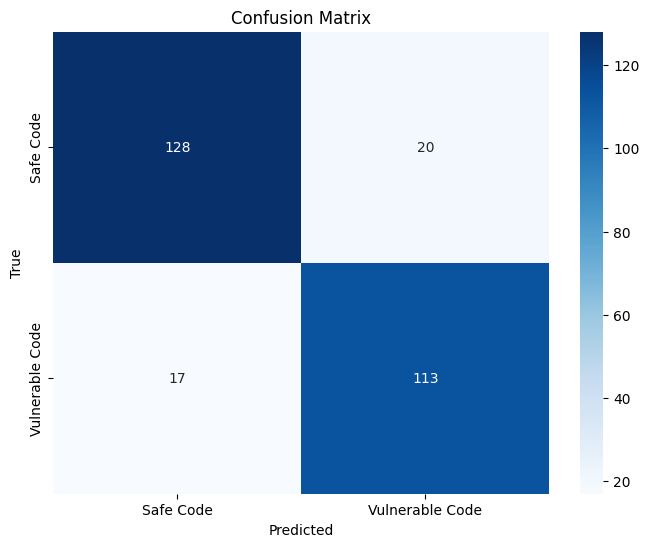

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

y_true = test_dataset['label']

# Assuming y_true and y_pred_new are already defined
# Encode labels
label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_true)
y_pred_new_encoded = label_encoder.transform(y_pred)

# Print classification report
print(classification_report(y_true_encoded, y_pred_new_encoded))

# Generate confusion matrix
cm = confusion_matrix(y_true_encoded, y_pred_new_encoded)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save_pretrained("codellama_detector")
tokenizer.save_pretrained("codellama_detector")